## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 9 - Rolling Optimization**

In [1]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
import helper
import stats
import dask
from dask import compute, delayed


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
from imp import reload  
reload(helper)
reload(stats)

<module 'stats' from 'e:\\My_Strategies_CTA\\stats.py'>

In [3]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [4]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #随便取一个商品期货，可以更改
print(product)
all_dates = os.listdir(DATA_PATH + "\\" + product)
all_dates.sort()
n_days = len(all_dates)
print(len(all_dates), all_dates[:6])

rb
1063 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [5]:
period = 4096

# train and test
train_sample = np.array(all_dates) < "2019"
test_sample = np.array(all_dates) > "2019"

# 记录时间的字符串和时间格式
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])


In [6]:
os.makedirs(HEAD_PATH+"\\all_signals", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
n_signal = len(all_signal_list)
signal_list = [signal+".4096" for signal in all_signal_list]

In [7]:
import sklearn.preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"


In [8]:
ori_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
signal_names = ori_mat.columns[0:-3]
signal_names
col_names = ori_mat.columns

In [9]:
train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
train_mat = train_mat[signal_names]
#train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=signal_names)
train_mat.shape

(4809, 45)

In [10]:
train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in ["hc","j","jm"]:
    cur_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

rb (4809, 48)
hc (4208, 48)
j (3639, 48)
jm (3403, 48)


In [11]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [12]:
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = model.coef_/x_std
print(fit_coef)

[-0.         -0.          0.01293634 -0.02785023 -0.00103634  0.02294916
  0.          0.         -0.         -0.         -0.          0.
 -0.         -0.00264385  0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.
 -0.         -0.0360791   0.          0.          0.         -0.
 -0.00874175 -0.          0.         -0.         -0.          0.00712943
  0.          0.         -0.        ]


In [13]:
coef_list=dict([])
for product in ["rb","hc","j","jm"]:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef)

rb
trade.imb.4096                           -0.000000
total.trade.imb.4096                     -0.000000
nr.4096                                   0.002510
dbook.4096                               -0.002366
range.pos.4096                           -0.000040
price.osci.4096                           0.000227
ma.dif.10.4096                            0.000000
kdj.k.4096                                0.000000
kdj.j.4096                               -0.000000
trade.imb.range.4096                     -0.000000
total.trade.imb.range.4096               -0.000000
nr.range.4096                             0.000000
dbook.range.4096                         -0.000000
range.pos.range.4096                     -0.000003
price.osci.range.4096                     0.000000
ma.dif.10.range.4096                      0.000000
kdj.k.range.4096                          0.000000
kdj.j.range.4096                         -0.000000
trade.imb.std.4096                       -0.000000
total.trade.imb.std.4096    

In [14]:
strat = "overall.lasso.002."+str(period)
for product in product_list:
    os.makedirs(HEAD_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [29]:
%%time
for product in {"rb","hc","j","jm"}:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

jm
j
hc
rb
Wall time: 2min 10s


In [ ]:
%%time
for product in {"rb","hc","j","jm"}:
        par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 17.5 s


In [ ]:
%%time
for product in {"rb","hc","j","jm"}:
    spread = product_info[product]["spread"]
    evaluate_signal("overall.lasso.002", np.array(all_dates), product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread*1.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 3min 38s


In [27]:
# we save the result of i lasso.002.4096 to another file overall.lasso.002.4096
signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+"i"+"."+"lasso.002.4096"+".trend.pkl")
save(signal_stat, HEAD_PATH+"\\signal_result_atr\\"+"i"+"."+"overall.lasso.002.4096"+".trend.pkl")

rb train sharpe  0.15871188774199899 test sharpe  0.326056896848912
hc train sharpe  0.38052252598063396 test sharpe  0.004471418524921818
i train sharpe  0.719225737312588 test sharpe  -0.8752812864853308
j train sharpe  0.4138635275391852 test sharpe  1.010661657729218
jm train sharpe  0.5112382790838763 test sharpe  -0.7491906653433114
train sharpe:  0.7114556723582379 test sharpe:  -0.3160581734667816


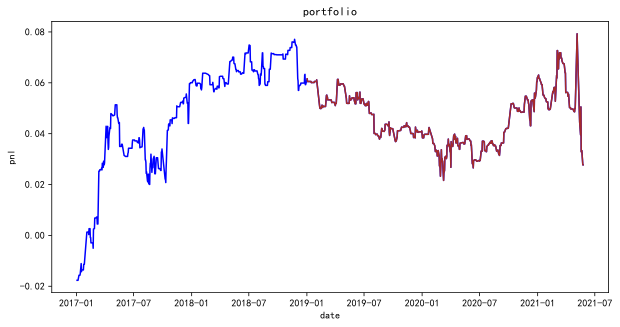

In [28]:
i = 0
strat = "overall.lasso.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 1
min_num = 5
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if sum(good_strat)>0:
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, all_portfolio.cumsum(), color="b")
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample], color="brown")
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))   

In [27]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    train_mat
    all_mat[product] = pd.concat((train_mat, test_mat))

In [28]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV

from sklearn.preprocessing import StandardScaler

In [29]:
month = np.array([file[:6] for file in all_dates])
month_len = np.unique(month, return_counts=True)
month_len

(array(['201701', '201702', '201703', '201704', '201705', '201706',
        '201707', '201708', '201709', '201710', '201711', '201712',
        '201801', '201802', '201803', '201804', '201805', '201806',
        '201807', '201808', '201809', '201810', '201811', '201812',
        '201901', '201902', '201903', '201904', '201905', '201906',
        '201907', '201908', '201909', '201910', '201911', '201912',
        '202001', '202002', '202003', '202004', '202005', '202006',
        '202007', '202008', '202009', '202010', '202011', '202012',
        '202101', '202102', '202103', '202104', '202105'], dtype='<U6'),
 array([18, 18, 23, 18, 20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22,
        20, 22, 23, 19, 18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 22, 20, 18,
        21, 22, 16, 20, 22, 21, 18, 20, 23, 21, 22, 16, 21, 23, 20, 15, 23,
        21, 10], dtype=int64))

In [30]:
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          single_product, combine_product, period=4096, SAVE_PATH=SAVE_PATH):
    product_list = np.append(single_product, combine_product)
    cum_daily_ticks = dict([])
    train_tick_start = dict([])
    train_tick_end = dict([])   
    test_tick_start = dict([])
    test_tick_end = dict([])   
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1)
        test_tick_start[product] = int(train_tick_end[product]+2)
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1])
        
    coef_list = dict([])
    for product in single_product:
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        n_train = x_train.shape[0]
        scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
        scaler.fit(x_train)
        x_std = np.sqrt(scaler.var_)
        x_train_normal = scaler.transform(x_train)
        model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
        coef = model.coef_ / x_std
        coef_list[product] = coef
    train_std_mat = dict([])
    train_std_mat
    n_samples = x_train.shape[0]
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in combine_product:
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_train = np.append(y_train, cur_y_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(train_mat, y_train)
    fit_coef = model.coef_
    for product in combine_product:
        coef_list[product] = fit_coef/train_std_mat[product]
    os.makedirs(SAVE_PATH+"\\models", exist_ok=True)
    save(coef_list, SAVE_PATH+"\\models\\"+strat+".pkl")
    


In [31]:
test_range = np.where((month_len[0] >= "2019"))[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2019")-1
cum_month_len = np.cumsum(month_len[1])

['201901' '201902' '201903' '201904' '201905' '201906' '201907' '201908'
 '201909' '201910' '201911' '201912' '202001' '202002' '202003' '202004'
 '202005' '202006' '202007' '202008' '202009' '202010' '202011' '202012'
 '202101' '202102' '202103' '202104' '202105']


In [32]:
%%time
strat = "universal.lasso.002.4096"
y_signal = "ret.4096.002"
start_month = 0
end_month = sum(month_len[0] < "2019")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                          ["i"], ["rb","hc","j","jm"], period=4096, SAVE_PATH=SAVE_PATH)
    start_month = start_month+1
    end_month = end_month+1

24 201901
25 201902
26 201903
27 201904
28 201905
29 201906
30 201907
31 201908
32 201909
33 201910
34 201911
35 201912
36 202001
37 202002
38 202003
39 202004
40 202005
41 202006
42 202007
43 202008
44 202009
45 202010
46 202011
47 202012
48 202101
49 202102
50 202103
51 202104
52 202105
Wall time: 35.9 s


In [33]:
%%time
start_month = 0
end_month = sum(month_len[0] < "2019")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    strat_name = strat+"."+month_len[0][i_test]
    coef_list = load(SAVE_PATH+"\\models\\"+strat_name+".pkl")
    for product in product_list:
        coef = coef_list[product]
        os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat_name, exist_ok=True)
        parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                  product=product, coef=coef, strat=strat_name, HEAD_PATH=HEAD_PATH,SAVE_PATH=SAVE_PATH)
    start_month = start_month+1
    end_month = end_month+1

24 201901
25 201902
26 201903
27 201904
28 201905
29 201906
30 201907
31 201908
32 201909
33 201910
34 201911
35 201912
36 202001
37 202002
38 202003
39 202004
40 202005
41 202006
42 202007
43 202008
44 202009
45 202010
46 202011
47 202012
48 202101
49 202102
50 202103
51 202104
52 202105
Wall time: 53min 56s


In [34]:
%%time
strat = "universal.lasso.002.4096"
start_month = 0
end_month = sum(month_len[0] < "2019")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    for product in product_list:
        par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH=SAVE_PATH)
    start_month = start_month+1
    end_month = end_month+1

201901 20170103.pkl 20181228.pkl
201902 20170203.pkl 20190131.pkl
201903 20170301.pkl 20190228.pkl
201904 20170405.pkl 20190329.pkl
201905 20170502.pkl 20190430.pkl
201906 20170601.pkl 20190531.pkl
201907 20170703.pkl 20190628.pkl
201908 20170801.pkl 20190731.pkl
201909 20170901.pkl 20190830.pkl
201910 20171009.pkl 20190930.pkl
201911 20171101.pkl 20191031.pkl
201912 20171201.pkl 20191129.pkl
202001 20180102.pkl 20191231.pkl
202002 20180201.pkl 20200123.pkl
202003 20180301.pkl 20200228.pkl
202004 20180402.pkl 20200331.pkl
202005 20180502.pkl 20200430.pkl
202006 20180601.pkl 20200529.pkl
202007 20180702.pkl 20200630.pkl
202008 20180801.pkl 20200731.pkl
202009 20180903.pkl 20200831.pkl
202010 20181008.pkl 20200930.pkl
202011 20181101.pkl 20201030.pkl
202012 20181203.pkl 20201130.pkl
202101 20190102.pkl 20201231.pkl
202102 20190201.pkl 20210129.pkl
202103 20190301.pkl 20210226.pkl
202104 20190401.pkl 20210331.pkl
202105 20190506.pkl 20210430.pkl
Wall time: 4min 41s


In [35]:
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal_result_atr", HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH):
    start_month = 0
    end_month = sum(month_len[0] < "2019")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"\\all_signals\\"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"\\"+save_path+"\\"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1

In [36]:
%%time
strat = "universal.lasso.002.4096"
for product in product_list:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=0.01)

rb 24 universal.lasso.002.4096.201901
rb 25 universal.lasso.002.4096.201902
rb 26 universal.lasso.002.4096.201903
rb 27 universal.lasso.002.4096.201904
rb 28 universal.lasso.002.4096.201905
rb 29 universal.lasso.002.4096.201906
rb 30 universal.lasso.002.4096.201907
rb 31 universal.lasso.002.4096.201908
rb 32 universal.lasso.002.4096.201909
rb 33 universal.lasso.002.4096.201910
rb 34 universal.lasso.002.4096.201911
rb 35 universal.lasso.002.4096.201912
rb 36 universal.lasso.002.4096.202001
rb 37 universal.lasso.002.4096.202002
rb 38 universal.lasso.002.4096.202003
rb 39 universal.lasso.002.4096.202004
rb 40 universal.lasso.002.4096.202005
rb 41 universal.lasso.002.4096.202006
rb 42 universal.lasso.002.4096.202007
rb 43 universal.lasso.002.4096.202008
rb 44 universal.lasso.002.4096.202009
rb 45 universal.lasso.002.4096.202010
rb 46 universal.lasso.002.4096.202011
rb 47 universal.lasso.002.4096.202012
rb 48 universal.lasso.002.4096.202101
rb 49 universal.lasso.002.4096.202102
rb 50 univer

sharpe  1.5329222886661156


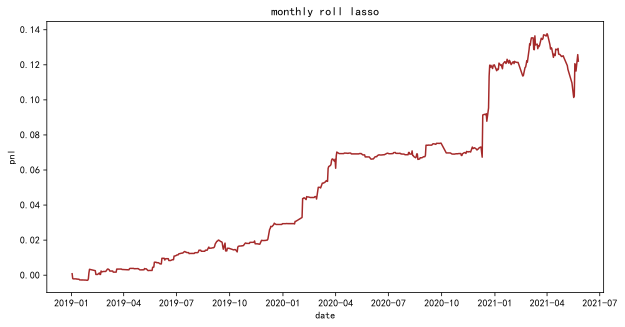

In [37]:
n_product = len(product_list)
save_path = "signal_result_atr"
strat = "universal.lasso.002.4096"
start_month = 0
end_month = sum(month_len[0] < "2019")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"\\"+save_path+"\\"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>1*spread) & (train_stat["final.result"]["num"]>0)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    avg_test_pnl = test_mat.mean(axis=1)
    #avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(10, 5))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], all_pnl.cumsum(), color="brown")
print("sharpe ", sharpe(all_pnl))